In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

In [45]:
def pend(x, t, m, Q, Bz, Ex, Ey):
    pos_x = x[0]
    vel_x = x[1]
    pos_y = x[2]
    vel_y = x[3]
    q = Q/m
    # w = 30.0
    # return np.array([vel_x, q*Ex*abs(np.cos(w*t)) + q*vel_y*Bz*np.cos(w*t),vel_y, q*Ey*np.sin(w*t)])
    return np.array([vel_x, q*Ex + q*vel_y*Bz,vel_y, q*Ey])

def solve_for_condition(c,t):
    x0 = c[:4]
    m, Q, Bz, Ex, Ey = c[4:-1]
    sol = odeint(pend, x0, t, args=(m, Q, Bz, Ex, Ey))
    valid_idx = np.where((abs(sol[:,0])<=1.0)&(abs(sol[:,2])<=0.7))[0]
    sol_ = np.concatenate((sol,t.reshape(-1,1)),axis=1)
    return sol_[valid_idx]

def gen_condition():
    particle = np.random.choice([0,1])
    pos_x = 0.0
    pos_y = np.random.normal(0.5,0.05)
    if particle == 0:
        vel_x = np.random.normal(53.6,4.18)
        vel_y = np.random.normal(1.3,0.61)
        # particle = np.random.choice([0.75,1.5])
        m = np.random.normal(0.75,0.21)*1.0E-4
        Q = np.random.normal(1.,0.36)*1.0E-10
    else:
        vel_x = np.random.normal(48.2,2.53)
        vel_y = np.random.normal(1.8,0.71)
        m = np.random.normal(0.95,0.35)*1.0E-4
        Q = np.random.normal(0.73,0.46)*1.0E-10
    Bz = np.random.normal(-1.,0.12)*1.0E-5
    Ex = np.random.normal(-2.5,0.2)*1.0E4
    Ey = np.random.normal(2.2,0.09)*1.0E3
    return pos_x, vel_x, pos_y, vel_y, m, Q, Bz, Ex, Ey,particle
    
def gen_conditions(N):
    C = []
    for i in range(N):
        C.append(gen_condition())
    return np.array(C)
            
def solve_for_conditions(C,t):
    sol = []
    for i in range(C.shape[0]):
        sol.append(solve_for_condition(C[i],t))
    return sol

In [50]:
%%time
N = 5000
C = gen_conditions(N)
t = np.linspace(0, 10, 50001)
sol = solve_for_conditions(C,t)

CPU times: user 4.74 s, sys: 3.3 ms, total: 4.74 s
Wall time: 4.73 s


In [51]:
C_df = pd.DataFrame(C,columns=["x0", "vx0", "y0", "vy0", "m", "Q", "Bz", "Ex", "Ey","particle"])

aux_df = pd.DataFrame(columns=["x", "vx", "y", "vy","t"])
for i in range(N):
    aux_df = pd.concat([aux_df,pd.DataFrame(sol[i][-1].reshape(1,-1),columns=["x", "vx", "y", "vy","t"])],axis=0)

result_df = pd.concat([C_df.reset_index(drop=True),aux_df.reset_index(drop=True)],axis=1)

df = result_df[['Q', 'Bz', 'Ex', 'Ey', 'particle', 'x', 'vx', 'y', 'vy']].copy()
df["particle"] = df["particle"].apply(lambda x: 0 if x < 0.9 else 1)

In [55]:
# df.to_csv("measurements.csv",index=None)
# C_df.to_csv("generated_data.csv",index=None)

In [52]:
df.corr("spearman")[["particle"]].sort_values("particle")

,particle
vx,-0.634150
Q,-0.268010
Bz,-0.005820
Ex,-0.002367
Ey,0.022683
x,0.074179
y,0.121661
vy,0.357281
particle,1.000000


---

In [56]:
from itertools import combinations

In [57]:
extra_df = df.copy()
for item in combinations(df.drop("particle",axis=1).columns.tolist(),2):
    extra_df[f'{item[0]}_by_{item[1]}'] = extra_df[item[0]] * extra_df[item[1]]

extra_df.corr("spearman")[["particle"]].sort_values("particle")

,particle
x_by_vx,-0.634640
vx,-0.634150
Ey_by_vx,-0.554481
Q_by_vx,-0.364108
Ex_by_vy,-0.351414
Bz_by_vy,-0.343416
vx_by_y,-0.319610
Q,-0.268010
Q_by_x,-0.267759
Q_by_Ey,-0.264801


---

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [10]:
def compute_cm(y_true,y_pred):
    return pd.DataFrame(
        confusion_matrix(y_true,y_pred),
        columns=["True negative","True positive"],
        index=["Pred. negative","Pred. positive"]
    )

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("particle",axis=1), df["particle"], test_size=0.33,random_state=42)

# model = SVC(C=1000.0)
model = RandomForestClassifier()
model.fit(X_train,y_train)

print("Train")
y_pred = model.predict(X_train)
print(classification_report(y_train,y_pred))
print(f"F1 score: {f1_score(y_train,y_pred):.3f}")
print(compute_cm(y_train,y_pred))

print("Test")
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print(f"F1 score: {f1_score(y_test,y_pred):.3f}")
compute_cm(y_test,y_pred)

Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1679
           1       1.00      1.00      1.00      1671

    accuracy                           1.00      3350
   macro avg       1.00      1.00      1.00      3350
weighted avg       1.00      1.00      1.00      3350

F1 score: 1.000
                True negative  True positive
Pred. negative           1679              0
Pred. positive              0           1671
Test
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       783
           1       0.81      0.85      0.83       867

    accuracy                           0.81      1650
   macro avg       0.81      0.81      0.81      1650
weighted avg       0.81      0.81      0.81      1650

F1 score: 0.827


,True negative,True positive
Pred. negative,607,176
Pred. positive,131,736


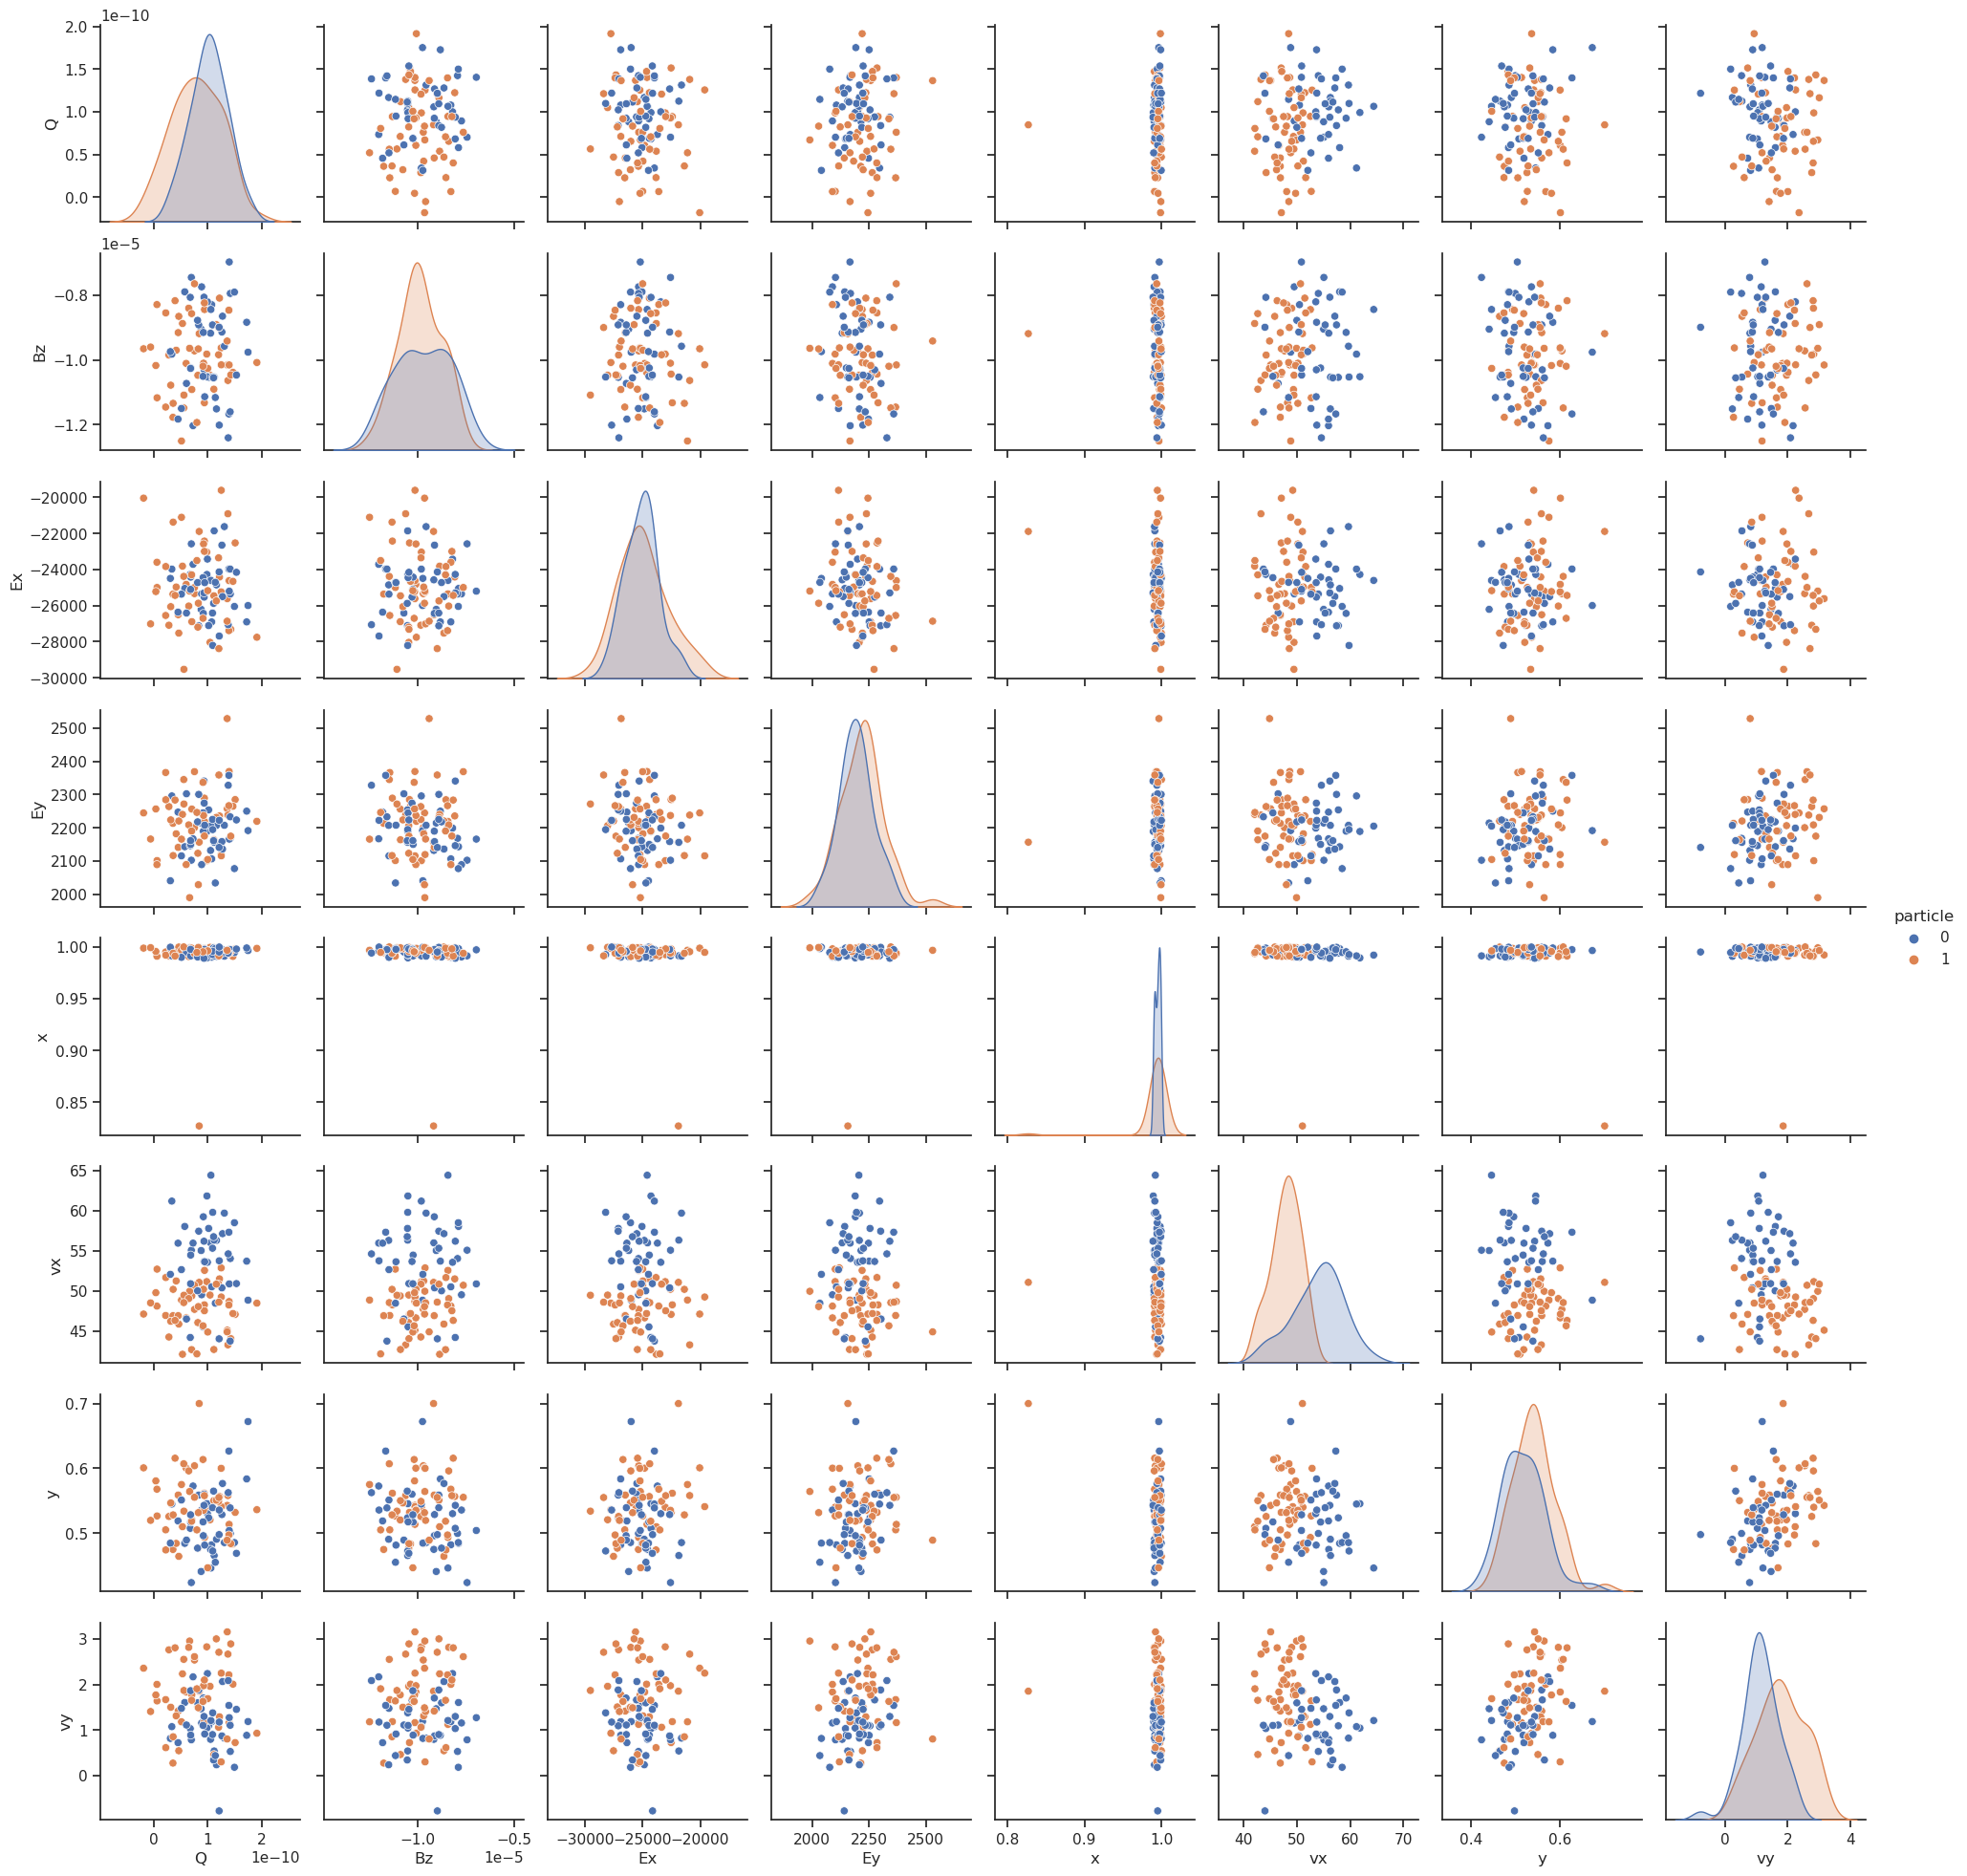

In [54]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(df.sample(n=100), hue="particle")

(11, 5)


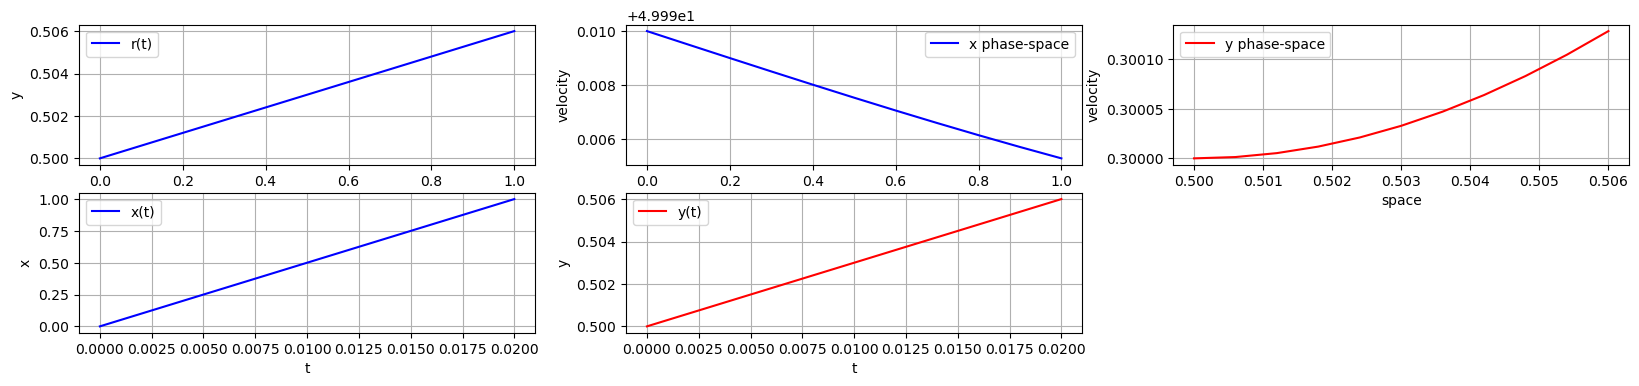

In [190]:
# x0, vx0, y0, vy0, m, Q, Bz, Ex, Ey
c = [0.0, 50.0, 0.5, 0.3,1.0E-5,1.0E-10,-1.0E-5,-2.5E4,2.2E3]
t = np.linspace(0, 1, 501)
sol = solve_for_condition(c,t)

pos_x = sol[:,0]
vel_x = sol[:,1]
pos_y = sol[:,2]
vel_y = sol[:,3]
t_eff = sol[:,4]

print(sol.shape)

plt.figure(figsize=(20,4))
plt.subplot(231)
plt.plot(pos_x, pos_y,color='blue', label='r(t)')
plt.legend(loc='best')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.subplot(232)
plt.plot(pos_x, vel_x, 'b', label='x phase-space')
plt.legend(loc='best')
plt.xlabel('space')
plt.ylabel('velocity')
plt.grid()
plt.subplot(233)
plt.plot(pos_y, vel_y, 'r', label='y phase-space')
plt.legend(loc='best')
plt.xlabel('space')
plt.ylabel('velocity')
plt.grid()
plt.subplot(234)
plt.plot(t_eff, pos_x, 'b', label='x(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.subplot(235)
plt.plot(t_eff, pos_y, 'r', label='y(t)')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()
plt.show()